### Strategy Idea 1 : Variation Trading

__Section 0: Setup__ Importing packages/reading in data etc.

__Section 1 : Idea__ 

- __1.1__ Strategy idea

- __1.2__ Origin of idea. Context/Reasoning for strategy to work e.g. use in financial markets?

__Section 2 : Exploration__

- __2.1__ Exploratory Data Analysis. e.g plots of price/volumes that could show strategy working, how much potential.

- __2.2__ Define some 'strategy metrics'. Metrics that can can you use to gauge if this strategy will work i.e no.price points above a certain threshold that is profitable. Metrics could show how often there is an opportunity to make a trade and how much 'value' is in an opportunity e.g. how much is there a price swing?

__Section 3 : Practical requirements__

- __3.1__ Identify if this edge is ‘realisable’? What methods will you apply to extract this value? e.g. applying a hedge function


- __3.2__ Is it possible to quantify the potential profit from the strategy? Consideration : How long will it take to obtain this? How 'risky' is it? e.g. if something did go wrong, how much do we lose? 

- __3.3__ Strategy limitations. The factors that could prevent strategy working e.g. practical considerations e.g. reacting quick enough to market updates, volume behind a price, size of bankroll needed


__Section 4: Potential limitations__

- __4.1__ What is our 'competition' - if not quantifiable, do we suspect people are doing the same thing? 

- __4.2__ So what's our edge? Identify ways of finding this edge in future? e.g what features are there? Are they predictive? Is there a certain 'market/runner' profile?

__Section 5 : Strategy testing__

- __5.1__ Testing strategy on previous data. 

- __5.2__ State any assumptions made by testing.

- __5.3__ Model refinements. How could strategy be optimised? Careful : is this backfitting/overfitting - what measures taken to negate this e.g. bootstrapping?

- __5.4__ Assessing strategy. P/L on data sample? ROI? variance in results? longest losing run?



### Section 0 : Setup

In [1]:
# importing packages
from pathlib import Path, PurePath 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# reading in data
project_dir = Path.cwd().parents[2]
data_dir = f"{project_dir}/data/processed/api/advanced/adv_data.csv"
df = pd.read_csv(data_dir, index_col = 0)

In [101]:
# defining variables
back_prices = [col for col in df.columns if 'BP' in col]
back_sizes = [col for col in df.columns if 'BS' in col]
lay_prices = [col for col in df.columns if 'LP' in col]
lay_sizes = [col for col in df.columns if 'LS' in col]
runner_info = ['SelectionId', 'MarketId', 'Venue', 'Distance', 'RaceType', 'BSP', 'NoRunners']

mids = df['MarketId'].unique()

### Section 1 : Idea

Due to the amount of variation during __inplay__ markets, I believe there is a profitable stragye to be had in back/laying a horse 'simultaneously at BSP' and looking the 'hedge' this during a race. 

origin - events that can happen within horse racing + difficulty for HR markets to be efficient i.e. high overround in play... 


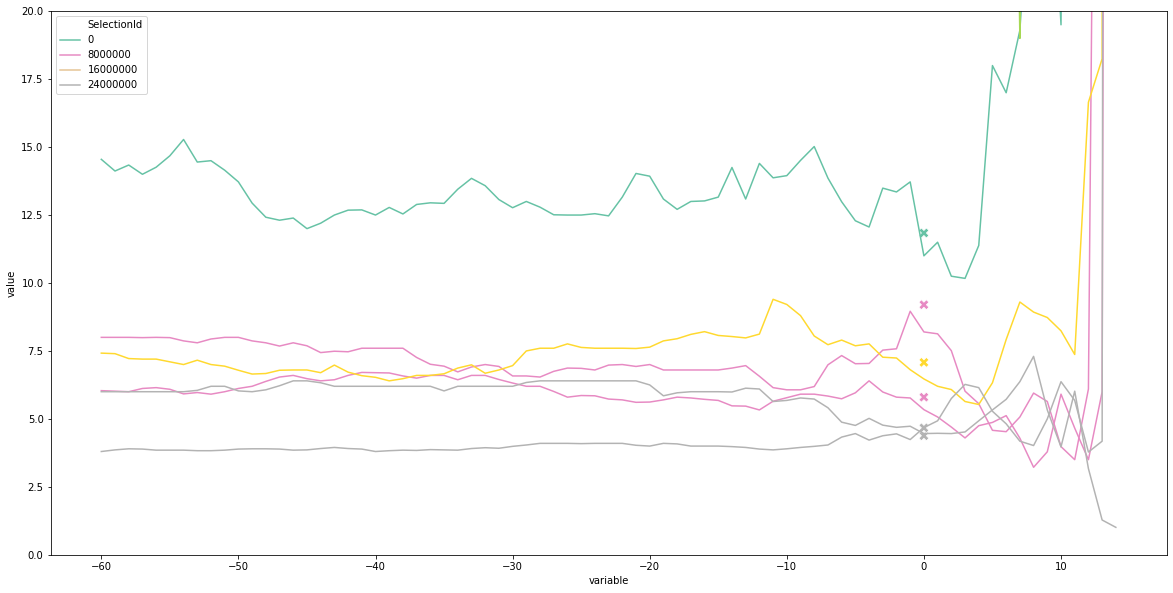

In [102]:
plot_df = df.loc[df['MarketId'].isin(mids[3:4])][['SelectionId']+back_prices].copy()
sep_df = df.loc[df['MarketId'].isin(mids[3:4])][['BSP', 'SelectionId']].copy()
plot_df.columns = plot_df.columns.str.replace("[BP:T]", "")
plot_df.columns = plot_df.columns.str.replace("[+]", "")

plot_df = pd.melt(plot_df, id_vars = ['SelectionId'])
plot_df['variable'] = plot_df['variable'].astype(int)

plt.figure(figsize=(20,10))
plt.ylim(0,20)


sns.scatterplot(np.zeros(plot_df['SelectionId'].nunique()), y = sep_df['BSP'],
                hue = sep_df['SelectionId'], palette = 'Set2', legend = False,
               marker = 'X', s=100)
sns.lineplot(x = 'variable', y = 'value',
             hue = 'SelectionId', data = plot_df, ci = None, palette = 'Set2')
          